# Sentiment Analysis

In [19]:
from bs4 import BeautifulSoup
import requests
import os
from os import path
import re
import pandas as pd
import numpy as np
from textblob import TextBlob
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter

## Helper functions

### Remove apostrophies from negotiations (don't, haven't, ...)

In [128]:
def write_out_negotiations(text):
    
    # haven't, hasn't

    text = re.sub("haven't", "have not", text)
    text = re.sub("Haven't", "Have not", text)
    text = re.sub("hasn't", "has not", text)
    text = re.sub("Hasn't", "Has not", text)

    ## isn't, can't, don't

    text = re.sub("mustn't", "must not", text)
    text = re.sub("Mustn't", "Must not", text)

    text = re.sub("can'", "can not", text)
    text = re.sub("Can't", "Can not", text)

    text = re.sub("isn't", "is not", text)
    text = re.sub("Isn't", "Is not", text)

    text = re.sub("aren't", "are not", text)
    text = re.sub("Aren't", "Are not", text)

    text = re.sub("don't", "do not", text)
    text = re.sub("Don't", "Do not", text)

    text = re.sub("doesn't", "does not", text)
    text = re.sub("doesn't", "does not", text)

    text = re.sub("didn't", "did not", text)
    text = re.sub("Didn't", "Did not", text)

    ## wasn't, won't

    text = re.sub("wasn't", "was not", text)
    text = re.sub("Wasn't", "Was not", text)

    text = re.sub("won't", "will not", text)
    text = re.sub("Won't", "Will not", text)

    ## wouldn't, couldn't

    text = re.sub("couldn't", "could not", text)
    text = re.sub("shouldn't", "should not", text)
    
    text = re.sub("“", "", text)
    text = re.sub("”", "", text)
    
    text = re.sub(r"\.", "", text)
    text = re.sub(";", "", text)
    text = re.sub(",", "", text)
    
    text = re.sub(r"\s\s", " ", text)
    text = text.strip()
    
    return text

In [129]:
# get list with all characters
characters_list = ["frodo", "gandalf", "sam", "merry", "pippin", "aragorn", "arwen", "eowyn", "legolas", "gimli", "theoden", "saruman", "gollum", "smeagol", "sauron"]

In [130]:
write_out_negotiations(gandalf)

"down from the door where it began and i must follow if i can the road goes ever on and on down from the door where it began now far ahead the road has gone and i must follow if i can a wizard is never late frodo baggins nor is he early he arrives precisely when he means to you did not think i'd miss your uncle bilbo's birthday? so how is the old rascal? i hear it's going to be a party of special magnificence well that should please him what? good gracious me indeed if you're referring to the incident with the dragon i was barely involved all i did was give your uncle a little nudge out of the door oh really? so am i dear boy so am i whoa whoa and what about very old friends? bilbo baggins good to see you 111 years old! who would believe it? you have not aged a day just tea thank you just tea thank you no not at all so you mean to go through with your plan? frodo suspects something you will tell him will not you? he's very fond of you whoa up they go! meriadoc brandybuck and peregrin t

In [133]:
with open("data/gandalf.txt") as f:
    gandalf = f.read()
    gandalf = write_out_negotiations(gandalf)
    gandalf_300_start = gandalf.split(' ')[:300]
    gandalf_300_end = gandalf.split(' ')[-300:]
with open("data/frodo.txt") as f:
    frodo = f.read()
    frodo = write_out_negotiations(frodo)
    frodo_300_start = frodo.split(' ')[:300]
    frodo_300_end = frodo.split(' ')[-300:]
with open("data/sam.txt") as f:
    sam = f.read()
    sam = write_out_negotiations(sam)
    sam_300_start = sam.split(' ')[:300]
    sam_300_end = sam.split(' ')[-300:]
with open("data/aragorn.txt") as f:
    aragorn = f.read()
    aragorn = write_out_negotiations(aragorn)
    aragorn_300_start = aragorn.split(' ')[:300]
    aragorn_300_end = aragorn.split(' ')[-300:]
with open("data/gollum_smeagol.txt") as f:
    gollum_smeagol = f.read()
    gollum_smeagol = write_out_negotiations(gollum_smeagol)
    gollum_smeagol_300_start = gollum_smeagol.split(' ')[:300]
    gollum_smeagol_300_end = gollum_smeagol.split(' ')[-300:]

## First Sentiment Analysis test using TextBlob

Info:
* Video: [Sentiment Analysis using Textblob](https://www.youtube.com/watch?v=6bg-TNoT5_Y)
* Text Tutorial: [Sentiment Analysis in Python with Textblob](https://stackabuse.com/sentiment-analysis-in-python-with-textblob/)
* Doku: [spacytextblob](https://spacy.io/universe/project/spacy-textblob)

Prerequisites:
spacy, language model "en_core_web_sm", textblob, textblob corpus, spacytextblob (spacy pipeline component) installed

textblob: `pip3 install -U textblob`
textblob corpus: `python -m textblob.download_corpora`
spacytextblob: `pip install spacytextblob`

In [136]:
# load spacy
nlp = spacy.load("en_core_web_sm")
# add Textblob to pipeline
nlp.add_pipe("spacytextblob")
# check if added to pipe
nlp.components

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x1e97b3bc220>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x1e97b406fe0>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x1e96c87d4d0>),
 ('senter', <spacy.pipeline.senter.SentenceRecognizer at 0x1e97b3be080>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x1e971f7a7c0>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x1e97b4a6100>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x1e977dba880>),
 ('spacytextblob',
  <spacytextblob.spacytextblob.SpacyTextBlob at 0x1e977d3e950>)]

In [137]:
# make doc of frodos dialog text
doc_frodo = nlp(frodo)
# frodo assessment
frodo_sa = doc_frodo._.assessments
frodo_sa_df = pd.DataFrame(frodo_sa, columns=["Word", "Polarity", "Subjectivity", "wtf"])
frodo_sa_df.insert(0, 'Number', range(1, 1 + len(frodo_sa_df)))
frodo_sa_df.insert(1, 'Character', 'Frodo')
frodo_sa_df

,Number,Character,Word,Polarity,Subjectivity,wtf
0,1,Frodo,[late],-0.300000,0.600000,None
1,2,Frodo,"[wonderful, !]",1.000000,1.000000,None
2,3,Frodo,[whole],0.200000,0.400000,None
3,4,Frodo,[half],-0.166667,0.166667,None
4,5,Frodo,[odd],-0.166667,0.250000,None
...,...,...,...,...,...,...
134,135,Frodo,[afraid],-0.600000,0.900000,None
135,136,Frodo,[last],0.000000,0.066667,None
136,137,Frodo,[whole],0.200000,0.400000,None
137,138,Frodo,[many],0.500000,0.500000,None


In [138]:
# make doc of gandalfs dialog text
doc_gandalf = nlp(gandalf)
# gandalf assessment
gandalf_sa = doc_gandalf._.assessments
gandalf_sa_df = pd.DataFrame(gandalf_sa, columns=["Word", "Polarity", "Subjectivity", "wtf"])
gandalf_sa_df.insert(0, 'Number', range(1, 1 + len(gandalf_sa_df)))
gandalf_sa_df.insert(1, 'Character', 'Gandalf')

In [139]:
# make doc of sams dialog text
doc_sam = nlp(sam)
# sam assessment
sam_sa = doc_sam._.assessments
sam_sa_df = pd.DataFrame(sam_sa, columns=["Word", "Polarity", "Subjectivity", "wtf"])
sam_sa_df.insert(0, 'Number', range(1, 1 + len(sam_sa_df)))
sam_sa_df.insert(1, 'Character', 'Sam')

In [140]:
# make doc of aragorns dialog text
doc_aragorn = nlp(aragorn)
# aragorn assessment
aragorn_sa = doc_aragorn._.assessments
aragorn_sa_df = pd.DataFrame(aragorn_sa, columns=["Word", "Polarity", "Subjectivity", "wtf"])
aragorn_sa_df.insert(0, 'Number', range(1, 1 + len(aragorn_sa_df)))
aragorn_sa_df.insert(1, 'Character', 'Aragorn')

In [141]:
# make doc of gollum_smeagols dialog text
doc_gollum_smeagol = nlp(gollum_smeagol)
# gollum_smeagol assessment
gollum_smeagol_sa = doc_gollum_smeagol._.assessments
gollum_smeagol_sa_df = pd.DataFrame(gollum_smeagol_sa, columns=["Word", "Polarity", "Subjectivity", "wtf"])
gollum_smeagol_sa_df.insert(0, 'Number', range(1, 1 + len(gollum_smeagol_sa_df)))
gollum_smeagol_sa_df.insert(1, 'Character', 'Gollum/Smeagol')

In [142]:
# concat single dataframes to one large dataframe
all_characters_sa_list = [frodo_sa_df, sam_sa_df, gandalf_sa_df, aragorn_sa_df, gollum_smeagol_sa_df]
all_characters_sa_df = pd.concat(all_characters_sa_list)

In [143]:
# reset index
all_characters_sa_df = all_characters_sa_df.sort_values("Number")
all_characters_sa_df.reset_index(drop=True, inplace=True)
all_characters_sa_df

,Number,Character,Word,Polarity,Subjectivity,wtf
0,1,Frodo,[late],-0.300000,0.600000,None
1,1,Gandalf,[down],-0.155556,0.288889,None
2,1,Aragorn,[far],0.100000,1.000000,None
3,1,Gollum/Smeagol,[precious],0.500000,1.000000,None
4,1,Sam,[good],0.700000,0.600000,None
...,...,...,...,...,...,...
959,320,Gandalf,[only],0.000000,1.000000,None
960,321,Gandalf,"[behind, !]",-0.500000,0.700000,None
961,322,Gandalf,[brave],0.800000,1.000000,None
962,323,Gandalf,[last],0.000000,0.066667,None


### Line plots

Text(0, 0.5, 'Polarity Index')

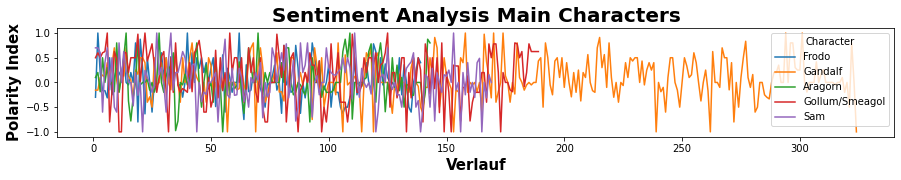

In [144]:
# Plot sentiment analysis for all characters
plt.figure(figsize=(15,2))
all_characters_sa_lineplot = sns.lineplot(x="Number", y="Polarity",
             hue="Character",
             data=all_characters_sa_df)
all_characters_sa_lineplot.set_title("Sentiment Analysis Main Characters", fontsize=20, fontweight="bold")
all_characters_sa_lineplot.set_xlabel("Verlauf", fontsize=15, fontweight="bold")
all_characters_sa_lineplot.set_ylabel("Polarity Index", fontsize=15, fontweight="bold")

Text(0, 0.5, 'Polarity Index')

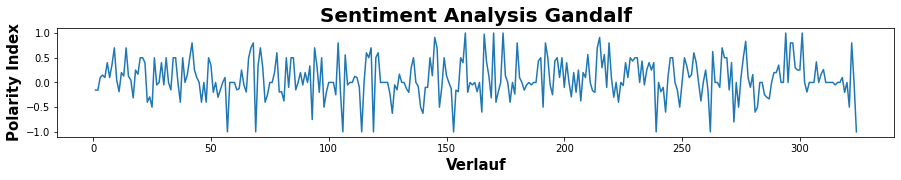

In [145]:
# Plot sentiment analysis gandalf
plt.figure(figsize=(15,2))
gandalf_sa_lineplot = sns.lineplot(x="Number", y="Polarity",
             data=gandalf_sa_df)
gandalf_sa_lineplot.set_title("Sentiment Analysis Gandalf", fontsize=20, fontweight="bold")
gandalf_sa_lineplot.set_xlabel("Verlauf", fontsize=15, fontweight="bold")
gandalf_sa_lineplot.set_ylabel("Polarity Index", fontsize=15, fontweight="bold")

Text(0, 0.5, 'Polarity Index')

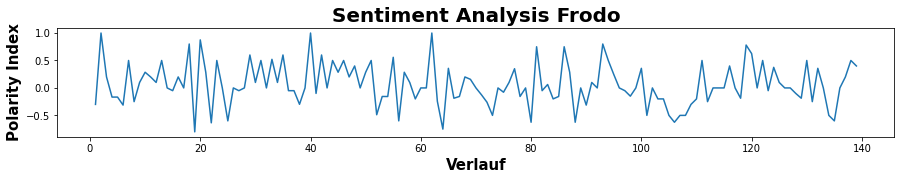

In [146]:
# Plot sentiment analysis frodo
plt.figure(figsize=(15,2))
frodo_sa_lineplot = sns.lineplot(x="Number", y="Polarity",
             data=frodo_sa_df)
frodo_sa_lineplot.set_title("Sentiment Analysis Frodo", fontsize=20, fontweight="bold")
frodo_sa_lineplot.set_xlabel("Verlauf", fontsize=15, fontweight="bold")
frodo_sa_lineplot.set_ylabel("Polarity Index", fontsize=15, fontweight="bold")

Text(0, 0.5, 'Polarity Index')

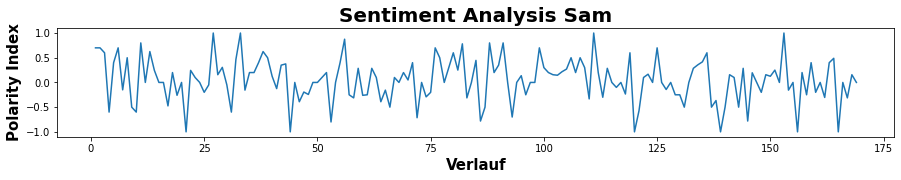

In [147]:
# Plot sentiment analysis sam
plt.figure(figsize=(15,2))
sam_sa_lineplot = sns.lineplot(x="Number", y="Polarity",
             data=sam_sa_df)
sam_sa_lineplot.set_title("Sentiment Analysis Sam", fontsize=20, fontweight="bold")
sam_sa_lineplot.set_xlabel("Verlauf", fontsize=15, fontweight="bold")
sam_sa_lineplot.set_ylabel("Polarity Index", fontsize=15, fontweight="bold")

Text(0, 0.5, 'Polarity Index')

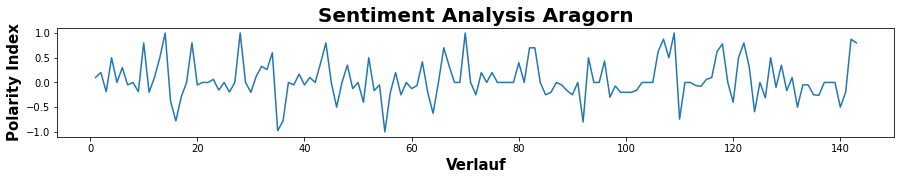

In [148]:
# Plot sentiment analysis gollum/smeagol
plt.figure(figsize=(15,2))
aragorn_sa_lineplot = sns.lineplot(x="Number", y="Polarity",
             data=aragorn_sa_df)
aragorn_sa_lineplot.set_title("Sentiment Analysis Aragorn", fontsize=20, fontweight="bold")
aragorn_sa_lineplot.set_xlabel("Verlauf", fontsize=15, fontweight="bold")
aragorn_sa_lineplot.set_ylabel("Polarity Index", fontsize=15, fontweight="bold")

In [149]:
aragorn_sa_df[aragorn_sa_df["Polarity"] > 0.99]

,Number,Character,Word,Polarity,Subjectivity,wtf
13,14,Aragorn,"[great, !]",1.0,0.75,None
27,28,Aragorn,"[brave, !, !]",1.0,1.00,None
69,70,Aragorn,[best],1.0,0.30,None
108,109,Aragorn,"[welcome, !, !, !, !, !, !, !, !]",1.0,0.90,None


Text(0, 0.5, 'Polarity Index')

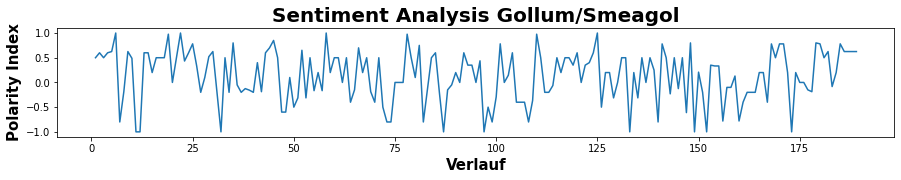

In [150]:
# Plot sentiment analysis gollum/smeagol
plt.figure(figsize=(15,2))
gollum_smeagol_sa_lineplot = sns.lineplot(x="Number", y="Polarity",
             data=gollum_smeagol_sa_df)
gollum_smeagol_sa_lineplot.set_title("Sentiment Analysis Gollum/Smeagol", fontsize=20, fontweight="bold")
gollum_smeagol_sa_lineplot.set_xlabel("Verlauf", fontsize=15, fontweight="bold")
gollum_smeagol_sa_lineplot.set_ylabel("Polarity Index", fontsize=15, fontweight="bold")